In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

### Reading data

Testing different datasets - clean with all 79 columns, and final with two different selections of 15 most important features.

In [2]:
data_c = pd.read_parquet('./Local/2017_Clean/Combined.parquet')
data_f1 = pd.read_parquet('./Local/2017_Final/Combined_1.parquet')
data_f2 = pd.read_parquet('./Local/2017_Final/Combined_2.parquet')

data_c = data_c.drop(columns=[' Label'])
data_f1 = data_f1.drop(columns=['Label'])
data_f2 = data_f2.drop(columns=['Label'])

### Reducing dimensionality with PCA
Additionally showing feature importantce measure.

In [18]:
datasets = {'Clean data': data_c, 'Final data 1': data_f1, 'Final data 2': data_f2}
pca_results = {}

In [19]:
for name, data in datasets.items():
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(data)
    pca_results[name] = pca_result
    
    print(f'--- {name} ---')
    print('Explained variation per principal component (PC): {}'.format(pca.explained_variance_ratio_))
    print('Cumulative variance explained by 2 principal components: {:.2%}\n'.format(np.sum(pca.explained_variance_ratio_)))

    data_pca = pd.DataFrame(abs(pca.components_), columns=data.columns, index=['PC_1', 'PC_2'])

    print(f'--- {name} ---')
    print('Most important features:\n')
    print('PC 1:\n', (data_pca[data_pca > 0.3].iloc[0]).dropna())   
    print('PC 2:\n', (data_pca[data_pca > 0.3].iloc[1]).dropna())
    print('\n')

--- Clean data ---
Explained variation per principal component (PC): [0.62860641 0.11010856]
Cumulative variance explained by 2 principal components: 73.87%

--- Clean data ---
Most important features:

PC 1:
  Flow Duration    0.435160
 Flow IAT Max     0.313612
Fwd IAT Total     0.434277
 Fwd IAT Max      0.314557
Idle Mean         0.301654
 Idle Max         0.312721
Name: PC_1, dtype: float64
PC 2:
  Flow Duration    0.309949
Fwd IAT Total     0.306129
Bwd IAT Total     0.624901
Name: PC_2, dtype: float64


--- Final data 1 ---
Explained variation per principal component (PC): [0.79193891 0.20800771]
Cumulative variance explained by 2 principal components: 99.99%

--- Final data 1 ---
Most important features:

PC 1:
 Total Length of Bwd Packets    0.707105
Subflow Bwd Bytes              0.707095
Name: PC_1, dtype: float64
PC 2:
 Packet Length Variance    0.99999
Name: PC_2, dtype: float64


--- Final data 2 ---
Explained variation per principal component (PC): [0.79197042 0.20801583

In [21]:
data = pca_results['Final data 1']

### Hyperparameter tuning using the silhouette method

In [22]:
def find_best_k(data, max_k):
    silhouette_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        
        labels = kmeans.fit_predict(data)
        
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append((k, silhouette_avg))
    
    return silhouette_scores

In [ ]:
max_k = 2
silhouette_scores = find_best_k(data, max_k)

In [ ]:
silhouette_df = pd.DataFrame(silhouette_scores, columns=['k', 'silhouette_score'])

plt.figure(figsize=(10, 6))
plt.plot(silhouette_df['k'], silhouette_df['silhouette_score'], marker='o')
plt.title('Silhouette Scores for Different k values')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
best_k = silhouette_df.loc[silhouette_df['silhouette_score'].idxmax()]['k']
print(f'The best number of clusters is: {best_k}')

### Running K-means

In [25]:
def k_means(data, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    kmeans.fit(data)
    
    centroids = kmeans.cluster_centers_
    closest_centroids = kmeans.labels_
    
    return centroids, closest_centroids

In [26]:
k = 2 #best_k

#centroids, closest_centroids = k_means(data_c.values, k)
centroids, closest_centroids = k_means(data_f1.values, k)
#centroids, closest_centroids = k_means(data_f2.values, k)

/run/media/arzaca/Maxtor/Network-Anomaly-Detection/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


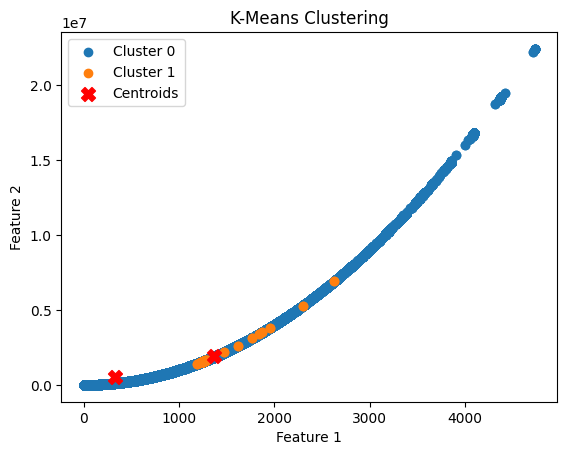

In [27]:
for i in range(k):
    cluster_points = data_f1.values[closest_centroids == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')

plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', label='Centroids', marker='X')

plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()